In [9]:
from scipy.io import wavfile
from scipy.signal.windows import kaiser
from scipy.signal import resample, resample_poly, convolve, correlate
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from transcoding import resample_decimate

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "Computer Modern Serif",
        "font.size": 24,
        "text.latex.preamble": "\n".join([r"\usepackage{siunitx}"]),
    }
)


In [10]:
f_pixel = int(2080 / 0.5)
f_sample = 20800
samples_per_pixel = f_sample // f_pixel

In [11]:
og_img = cv2.imread("input/eye.jpg")
gray = cv2.cvtColor(og_img, cv2.COLOR_BGR2GRAY)

h, w = gray.shape
width = 909 * samples_per_pixel

img = cv2.resize(gray, (width, int(h / w * width)))  # (width, height)
inverted_img = 255 - img

img = (img / 255.0) * 2 - 1
inverted_img = (inverted_img / 255.0) * 2 - 1

(3030, 4545)


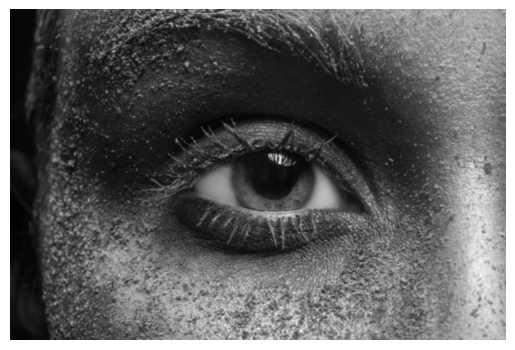

In [12]:
print(img.shape)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

39


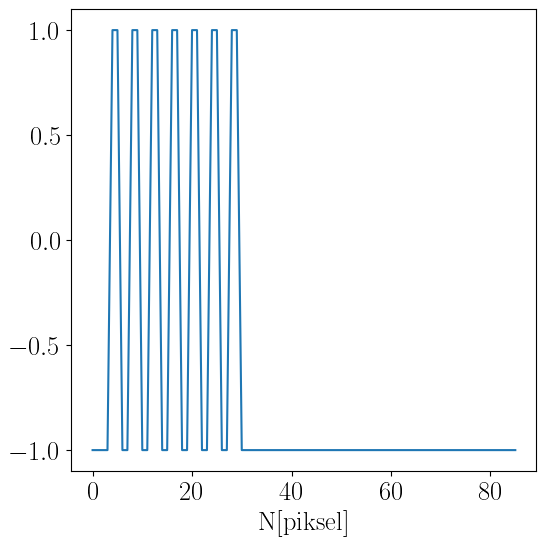

In [ ]:
sync_frame_str0 = "000011001100110011001100110011000000000"
sync_frame_str1 = "000011100111001110011100111001110011100"
sync_frame0 = [int(x) * 2 - 1 for x in sync_frame_str0] + [-1 for _ in range(47)]
sync_frame1 = [int(x) * 2 - 1 for x in sync_frame_str1] + [-1 for _ in range(47)]

telemetry = [-1 for _ in range(45)] # blank

#sync_frame0 = np.repeat(sync_frame0, samples_per_pixel)
#sync_frame1 = np.repeat(sync_frame1, samples_per_pixel)
telemetry = np.repeat(telemetry, samples_per_pixel)

plt.figure(figsize=(6, 6))
print(len(sync_frame_str1))
plt.rcParams.update({'font.size': 19})
plt.xlabel("N[piksel]")
plt.plot(sync_frame0)
#plt.savefig("images/sync_frame0.pdf")

In [14]:
signal = []


for i in range(img.shape[0]):
    line = np.concat([sync_frame0, img[i], telemetry, sync_frame1, inverted_img[i], telemetry])
    signal.append(line)

signal = np.concat(signal)

In [15]:
f_carrier = 2400

m = 0.7
t = np.arange(signal.shape[0]) / f_sample
A = 1
c = A * np.sin(2 * np.pi * f_carrier * t)
signal = (1 + m * signal) * c
signal = signal / np.max(np.abs(signal))

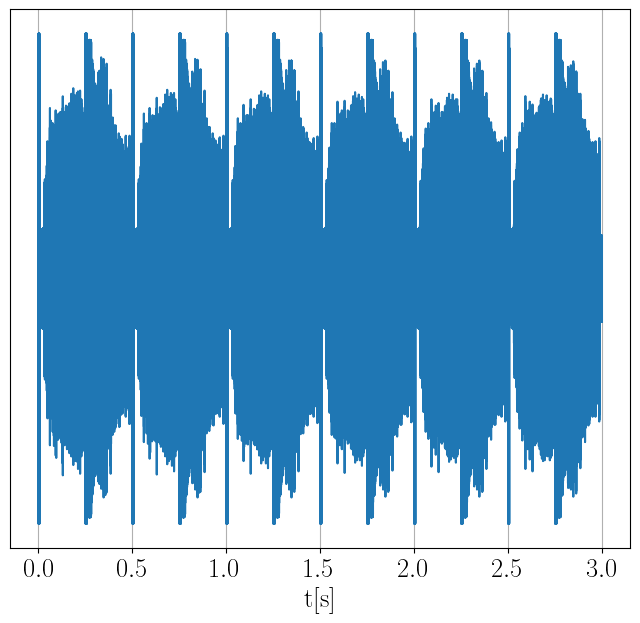

In [16]:
plt.figure(figsize=(8, 7))
plt.plot([i / f_sample for i in range(3 * f_sample)], signal[f_sample * 2: f_sample * 5])
plt.xlabel("t[s]")
plt.yticks([])
plt.grid()
plt.savefig("images/signal_example.pdf")

In [17]:
signal = np.int16(signal * 32767)
wavfile.write("input/eye.wav", f_sample, signal)